## Import Pytorch Geometric and PyTorch

In [ ]:
# Install required packages.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric 

In [2]:
import numpy as np
import pandas as pd
from statistics import mean, stdev
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_score, f1_score, recall_score, accuracy_score

from torch_geometric.utils import dense_to_sparse, index_to_mask
from torch_geometric.data import Data
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU
from torch_geometric.nn import GCNConv, GATConv, SAGEConv, GINConv

## Setup GNNs

GCN

In [15]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        return x

GCN(
  (conv1): GCNConv(177, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (conv4): GCNConv(16, 4)
)


GAT

In [16]:
class GAT(torch.nn.Module):
    def __init__(self, hidden_channels=16, num_heads=2):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(data.num_features, int(hidden_channels / num_heads), heads=num_heads)
        self.conv2 = GATConv(hidden_channels, int(hidden_channels / num_heads), heads=num_heads)
        self.conv3 = GATConv(hidden_channels, int(hidden_channels / num_heads), heads=num_heads)
        self.conv4 = GATConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        return x

GAT(
  (conv1): GATConv(177, 8, heads=2)
  (conv2): GATConv(16, 8, heads=2)
  (conv3): GATConv(16, 8, heads=2)
  (conv4): GATConv(16, 4, heads=1)
)


SAGE

In [17]:
class SAGE(torch.nn.Module):
    def __init__(self, hidden_channels=16):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = SAGEConv(data.num_features, hidden_channels, project=True)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels, project=True)
        self.conv3 = SAGEConv(hidden_channels, hidden_channels, project=True)
        self.conv4 = SAGEConv(hidden_channels, data.num_classes, project=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv4(x, edge_index)
        return x

SAGE(
  (conv1): SAGEConv(177, 16, aggr=mean)
  (conv2): SAGEConv(16, 16, aggr=mean)
  (conv3): SAGEConv(16, 16, aggr=mean)
  (conv4): SAGEConv(16, 4, aggr=mean)
)


GIN

In [18]:
class GIN(torch.nn.Module):
    def __init__(self, hidden_channels=8):
        super(GIN, self).__init__()
        self.conv1 = GINConv(
            Sequential(Linear(data.num_features, hidden_channels),
                       BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv2 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.conv3 = GINConv(
            Sequential(Linear(hidden_channels, hidden_channels), BatchNorm1d(hidden_channels), ReLU(),
                       Linear(hidden_channels, hidden_channels), ReLU()))
        self.lin1 = Linear(hidden_channels*4, hidden_channels*4)
        self.lin2 = Linear(hidden_channels*4, data.num_classes)

    def forward(self, x, edge_index):
        h1 = self.conv1(x, edge_index)
        h2 = self.conv2(h1, edge_index)
        h3 = self.conv3(h2, edge_index)
        h4 = self.conv3(h3, edge_index)

        h = torch.cat((h1, h2, h3, h4), dim=1)

        h = self.lin1(h)
        h = h.relu()
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.lin2(h)
        
        return h

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=177, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=32, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=4, bias=True)
)


## Set Up Train and Test Functions

In [19]:
def train():
      model.train()
      optimizer.zero_grad()
      out = model(data.x, data.edge_index) 
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward() 
      optimizer.step()
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1) 
      y_pred = pred[data.test_mask]
      y_true = data.y[data.test_mask]
      test_acc = accuracy_score(y_true, y_pred)
      test_auc = roc_auc_score(label_binarize(y_true, classes=[0,1,2,3]), 
                               label_binarize(y_pred, classes=[0,1,2,3]), 
                               multi_class='ovo')
      test_precision = precision_score(y_true, y_pred, average='macro')
      test_f1 = f1_score(y_true, y_pred, average='macro')
      test_recall = recall_score(y_true, y_pred, average='macro')
      return test_acc, test_auc, test_precision, test_recall, test_f1

## K-Fold Cross Validation

In [ ]:
raw = pd.get_dummies(pd.read_csv('ManualPreprocessedAmesHousingClassification.csv'))

X = MinMaxScaler().fit_transform(raw.drop('SalePrice', axis=1).to_numpy())
y = raw['SalePrice'].to_numpy()

ksplit = StratifiedKFold(n_splits=5)
knn = torch.Tensor(kneighbors_graph(X, n_neighbors=10).toarray())
edge_index, _ = dense_to_sparse(knn)

acc = []
auc = []
precision = []
recall = []
f1 = []

for train_idx, test_idx in ksplit.split(X, y):
    data = Data(x=torch.Tensor(X), edge_index=edge_index, y=torch.Tensor(y).long())
    data.train_mask = index_to_mask(torch.Tensor(train_idx).long(), size=len(y))
    data.test_mask = index_to_mask(torch.Tensor(test_idx).long(), size=len(y))
    data.num_features = X.shape[1]
    data.num_classes = 4

    model = GIN()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 401):
        loss = train()
        # print(f'Epoch: {epoch:03d}, CELoss: {loss:.4f}')

    test_acc, test_auc, test_precision, test_recall, test_f1 = test()
    acc.append(test_acc)
    auc.append(test_auc)
    precision.append(test_precision)
    recall.append(test_recall)
    f1.append(test_f1)


print(acc)
print(f'acc: {mean(acc):.4f}, {stdev(acc):.4f}')
print(f'auc: {mean(auc):.4f}, {stdev(auc):.4f}')
print(f'precision:, {mean(precision):.4f}, {stdev(precision):.4f}')
print(f'recall: {mean(recall):.4f}, {stdev(recall):.4f}')
print(f'f1: {mean(f1):.4f}, {stdev(f1):.4f}')

## Plot k-NN graph vs. SAGE Test Statistics

In [13]:
raw = pd.get_dummies(pd.read_csv('ManualPreprocessedAmesHousingClassification.csv'))

X = MinMaxScaler().fit_transform(raw.drop('SalePrice', axis=1).to_numpy())
y = raw['SalePrice'].to_numpy()

index = np.arange(len(y))
np.random.shuffle(index)
threshold = int(len(y) * 0.8)

train_index = index[:threshold]
test_index = index[threshold:]

acc = []
auc = []
precision = []
recall = []
f1 = []

for k in range(4, 24, 1):
    knn = torch.Tensor(kneighbors_graph(X, n_neighbors=k).toarray())
    edge_index, _ = dense_to_sparse(knn)

    data = Data(x=torch.Tensor(X), edge_index=edge_index, y=torch.Tensor(y).long())
    data.train_mask = index_to_mask(torch.Tensor(train_index).long(), size=len(y))
    data.test_mask = index_to_mask(torch.Tensor(test_index).long(), size=len(y))
    data.num_features = X.shape[1]
    data.num_classes = 4

    model = SAGE()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-5)
    criterion = torch.nn.CrossEntropyLoss()

    for epoch in range(1, 401):
        loss = train()

    test_acc, test_auc, test_precision, test_recall, test_f1 = test()
    acc.append(test_acc)
    auc.append(test_auc)
    precision.append(test_precision)
    recall.append(test_recall)
    f1.append(test_f1)

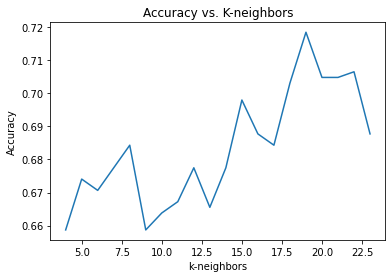

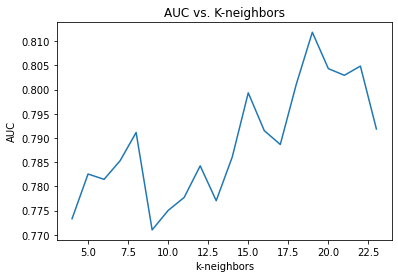

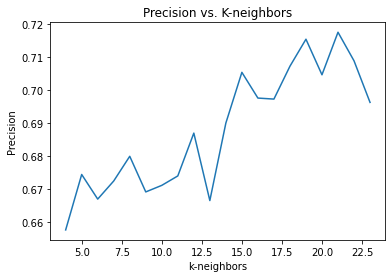

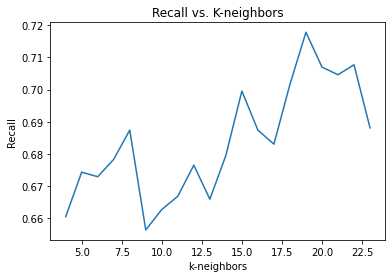

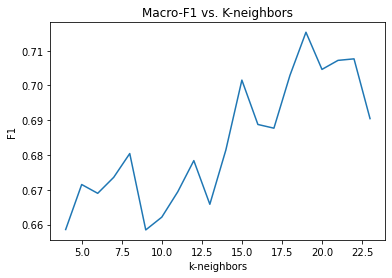

In [14]:
plt.plot(range(4, 24, 1), acc)
plt.title('Accuracy vs. K-neighbors')
plt.xlabel('k-neighbors')
plt.ylabel('Accuracy')
plt.savefig('acc.png')
plt.show()

plt.plot(range(4, 24, 1), auc)
plt.title('AUC vs. K-neighbors')
plt.xlabel('k-neighbors')
plt.ylabel('AUC')
plt.savefig('auc.png')
plt.show()

plt.plot(range(4, 24, 1), precision)
plt.title('Precision vs. K-neighbors')
plt.xlabel('k-neighbors')
plt.ylabel('Precision')
plt.savefig('precision.png')
plt.show()

plt.plot(range(4, 24, 1), recall)
plt.title('Recall vs. K-neighbors')
plt.xlabel('k-neighbors')
plt.ylabel('Recall')
plt.savefig('recall.png')
plt.show()

plt.plot(range(4, 24, 1), f1)
plt.title('Macro-F1 vs. K-neighbors')
plt.xlabel('k-neighbors')
plt.ylabel('F1')
plt.savefig('f1.png')
plt.show()